In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, randint, spearmanr, uniform, loguniform
from skelm import ELMRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import (make_scorer, max_error, mean_squared_error,
                             median_absolute_error)
from sklearn.model_selection import (BaseCrossValidator, KFold,
                                     RandomizedSearchCV)
from tqdm import tqdm
from xgboost import XGBRegressor

In [12]:
# TODO: holdout test set
def load_dataset(image, annotation, height_threshold=float('-inf')):
    # Load dataset image
    with rasterio.open(image) as src:
        raster = src.read()
        bands = src.count
        labels = list(src.descriptions)
        X = raster.transpose(1, 2, 0).reshape(-1, bands)

    # Load annotation
    with rasterio.open(annotation) as src:
        y = src.read(1).flatten()

    drop_labels = []
    for i, label in enumerate(labels):
        if np.isnan(X[:, i]).all():
            drop_labels.append(label)
    
    # drop bands with no data
    for label in reversed(drop_labels):
        X = np.delete(X, labels.index(label), axis=1)
        labels.remove(label)

    # remove nan values
    mask = ~np.isnan(X).any(axis=1)  # nan in any band
    mask = np.logical_and(mask, ~np.isnan(y))  # nan in annotation
    mask = np.logical_and(mask, X[:, labels.index('b1')] > height_threshold)  # height threshold
    X = X[mask]
    y = y[mask]

    # prettify labels
    pretty_labels = []
    for label in labels:
        label = label.replace('_', ' ')
        pretty_label = ' '.join([word[0].upper() + word[1:]
                                 for word in label.split()])
        pretty_labels.append(pretty_label)

    return X, y, labels

class EndMemberSplitter(BaseCrossValidator):
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.k_fold = KFold(n_splits=n_splits, shuffle=shuffle,
                            random_state=random_state)

    def split(self, X, y, groups=None):
        for train, test in self.k_fold.split(X, y):
            end_member_train = np.where((y[train] == 0)
                                        | (y[train] == 1))[0]
            yield end_member_train, test

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

# Load the dataset
height_threshold = 10
X, y, labels = load_dataset('../data/interim/fusion.tif', '../data/interim/plot.tif', height_threshold=height_threshold)

c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\hofin\mambaforge\envs\ltm\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


2.28327259272291e-06 1.0
Most similar pairs:
b1_inertia  b1_contrast    1.000000
b1_prom     b1_svar        0.997937
0_1_B8A     0_1_B6         0.995163
0_2_B8A     0_2_B6         0.995111
b1_var      b1_contrast    0.994214
dtype: float64


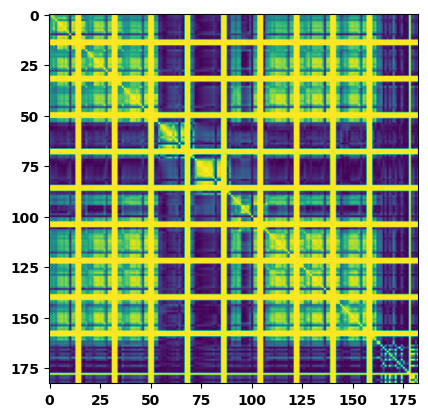

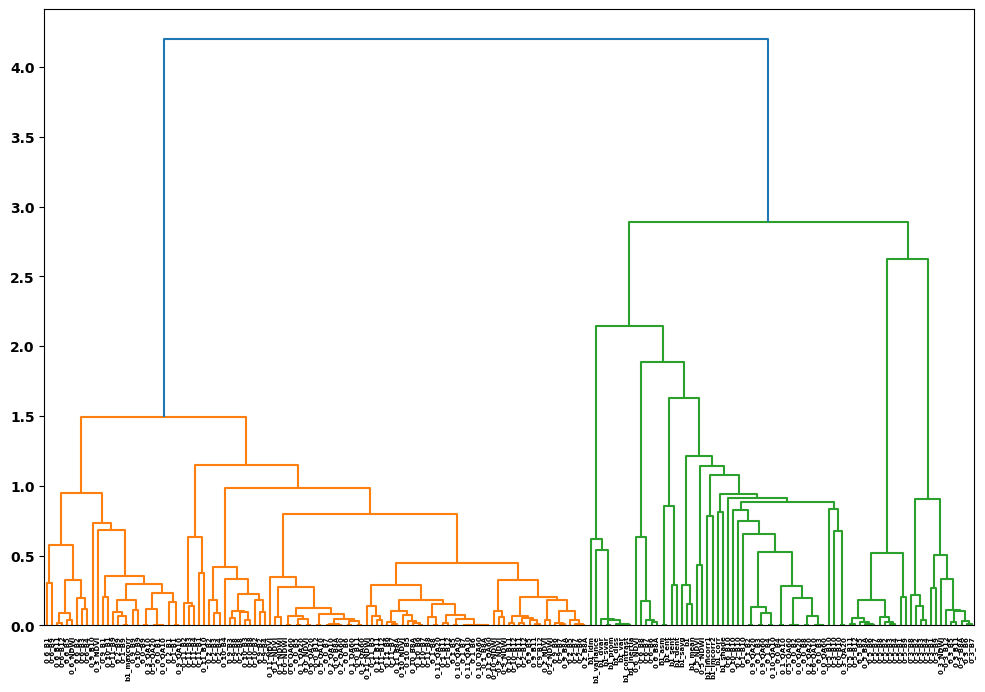

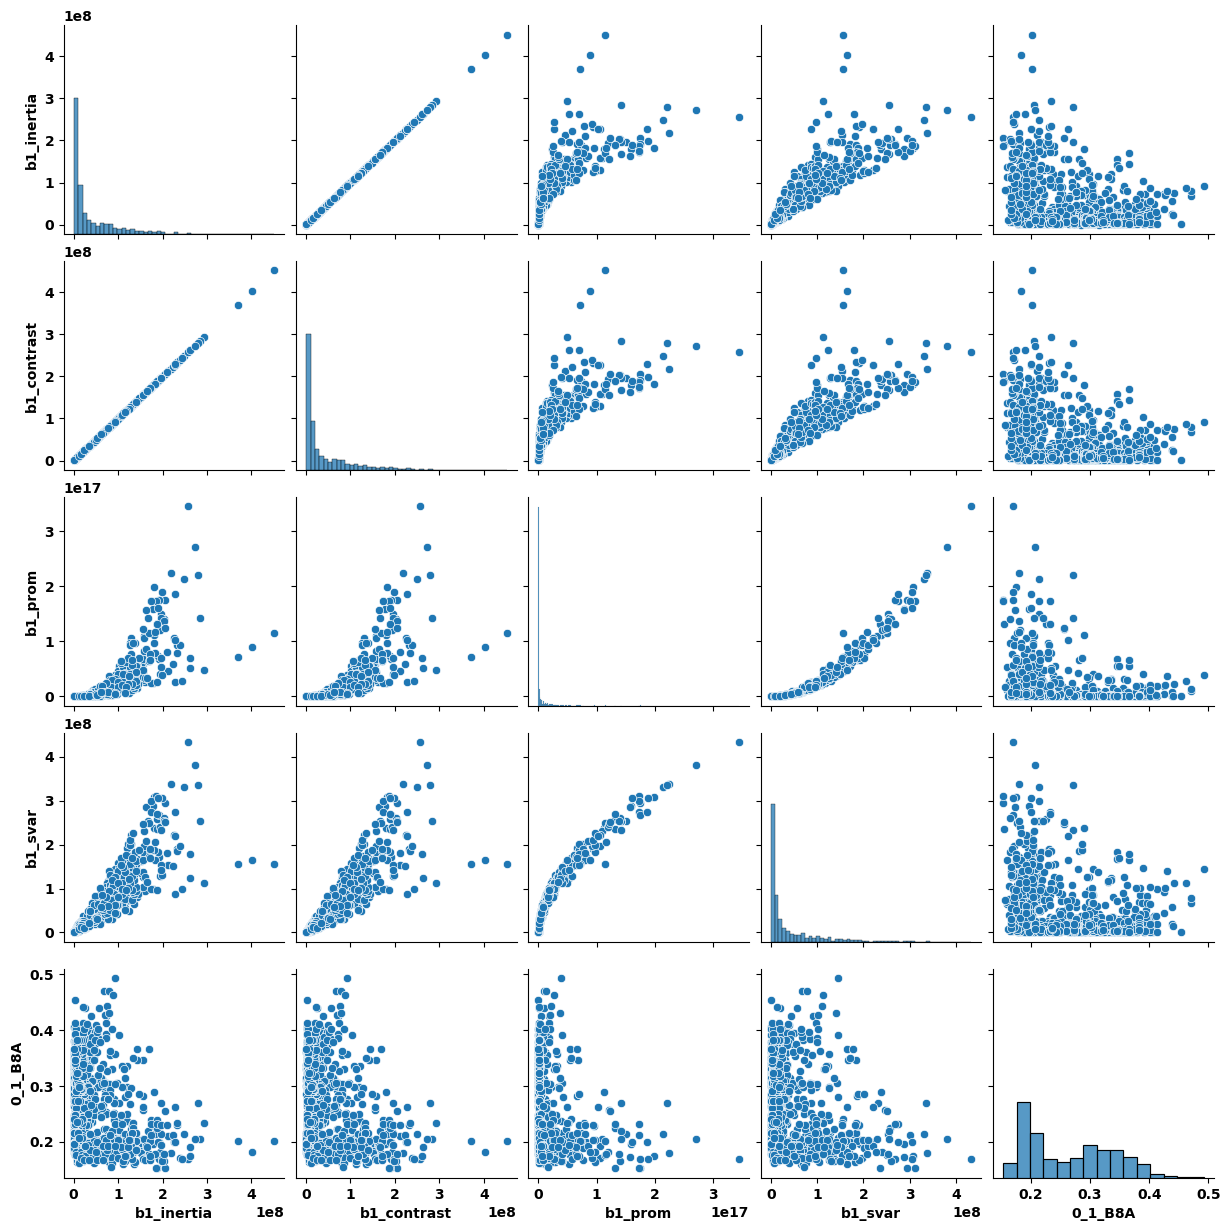

In [3]:
def similarity_matrix(X, method='spearman'):
    if method == 'spearman':
        similarity = spearmanr(X).correlation
    elif method == 'pearson':
        similarity = pearsonr(X).correlation
    elif method == 'mutual_info':
        similarity = np.full((X.shape[1], X.shape[1]), np.nan)
        for i, band_1 in tqdm(enumerate(X.T)):
            if band_1.std() == 0: continue
            for j, band_2 in enumerate(X.T):
                if band_2.std() == 0: continue
                similarity[i, j] = mutual_info_regression(band_1.reshape(-1, 1),
                                                          band_2)[0]
    else:
        raise ValueError(f'Unknown method: "{method}"')
    
    # Ensure the correlation matrix is normalized and symmetric
    np.fill_diagonal(similarity, 0)
    # similarity += np.nanmin(similarity)
    similarity = abs(similarity)
    similarity /= np.nanmax(similarity)
    similarity = (similarity + similarity.T) / 2
    similarity[np.isnan(similarity)] = 1
    np.fill_diagonal(similarity, 1)

    return similarity

def plot_dendrogram(similarity_matrix, labels):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()

    distance_matrix = 1 - np.abs(similarity_matrix)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=labels, ax=ax, leaf_rotation=90
    )

    return dendro

def hierarchial_dim_red(X, labels, similarity_matrix, threshold=0.2):
    distance_matrix = 1 - np.abs(similarity_matrix)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))

    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
        
    return X[:, selected_features], [labels[i] for i in selected_features]

def pairplot(X, labels, similar_labels):
    similar_indices = [labels.index(label) for label in similar_labels]
    similar_df = pd.DataFrame(X[:, similar_indices], columns=similar_labels)

    sns.pairplot(similar_df)

def get_similar_labels(similarity_matrix, labels, num_labels=None, reversed=False, ignore_ones=False):
    similarity_matrix = similarity_matrix.copy()

    # Fill lower triangle with NaNs
    similarity_matrix[np.tril_indices(similarity_matrix.shape[0], -1)] = np.nan

    # Replace 1s with NaNs if requested
    if ignore_ones:
        similarity_matrix[similarity_matrix == 1] = np.nan
    corr_matrix = pd.DataFrame(similarity_matrix, columns=labels, index=labels)

    # Sort by correlation
    corr_matrix = corr_matrix.abs()
    corr_matrix = corr_matrix.unstack()
    corr_matrix = corr_matrix.sort_values(ascending=reversed)
    print('Most similar pairs:')
    print(corr_matrix.head(num_labels))
    corr_pairs = corr_matrix.index

    corr_columns = []
    redundant_columns = (num for tup in corr_pairs for num in tup)  # flatten
    for column in redundant_columns:
        if column not in corr_columns:
            corr_columns.append(column)
            if num_labels is not None and len(corr_columns) >= num_labels:
                break

    return corr_columns

# Draw interesting plots
similarity = similarity_matrix(X, method='spearman')#  'mutual_info')#  
print(similarity.min(), similarity.max())
plt.imshow(similarity)
plot_dendrogram(similarity, labels)
similar_labels = get_similar_labels(similarity, labels, num_labels=5, ignore_ones=True)
pairplot(X, labels, similar_labels)

# Dimensionality reduction
# X, labels = hierarchial_dim_red(X, labels, similarity, threshold=0.2)  # reduces performance significantly
plt.show()

In [4]:
# Define the scorers
scorers = {'max_error': make_scorer(max_error, greater_is_better=False),
           'median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
           'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}
refit = 'mean_squared_error'  # scorer for best model selection

# Define the models and hyperparameter search space
# Possible distributions: expon, gamma, uniform, loguniform or randint
# Random state will be set by sklearn, if scipy >= 0.16 is available
models = {
    ELMRegressor(): {
        'alpha': loguniform(1e-8, 1e5),
        'include_original_features': [True, False],
        'n_neurons': loguniform(1, 100-1),
        'ufunc': ['tanh', 'sigm', 'relu', 'lin'],
        'density': uniform(0.01, 0.99),
    },
    XGBRegressor(): {
        'n_estimators': randint(10, 100-10),
        'max_depth': randint(1, 20),
        'learning_rate': uniform(0.01, 0.5),
        'gamma': uniform(0, 0.5),
        'min_child_weight': randint(1, 11),
    },
    RandomForestRegressor(): {
        'n_estimators': randint(1, 100-1),
        'max_depth': randint(1, 20),
        'max_features': randint(1, 11),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 11),
        'bootstrap': [True, False],
        'criterion': ['squared_error', 'absolute_error', 'poisson', 'friedman_mse'],
    },
    ExtraTreesRegressor(): {
        'n_estimators': randint(1, 100-1),
        'min_impurity_decrease': loguniform(1e-5, 0.5),
        'criterion': ['squared_error', 'absolute_error'],
    },
}

# Define the search strategy
search = RandomizedSearchCV
search_kwargs = dict(cv=EndMemberSplitter(5, shuffle=True), return_train_score=True, n_iter=10, verbose=1, random_state=0)  # , n_jobs=-1, KFold(n_splits=5)

# Perform hyperparameter optimization using the defined search
best_models = []
cv_results = []
for model, param_distributions in models.items():
    current_search = search(model, param_distributions, 
                               scoring=scorers, refit=refit, **search_kwargs)
    current_search.fit(X, y)

    best_models.append(current_search.best_estimator_)
    cv_results.append(current_search.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Set colors for plotting
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot the results for each parameter of each model
for results, (model, param_distributions) in zip(cv_results, models.items()):
    for parameter in param_distributions.keys():
        # Skip if parameter is not convertible to float
        try:
            X_axis = np.array(results[f"param_{parameter}"].data, dtype=float)
        except ValueError:
            continue

        # Setup plot
        plt.figure(figsize=(13, 13))
        ax = plt.subplot()
        ax.set_xlabel(parameter)
        ax.set_ylabel("score")
        ax.set_ylim(0, 1)

        # Sort results by parameter value
        sort_idx = np.argsort(X_axis)
        X_axis = X_axis[sort_idx]
        results = {key: np.array(value)[sort_idx] for key, value in results.items()}

        # Plot the different metrics
        for (metric_name, scorer), color in zip(scorers.items(), colors):
            for sample, style in (("train", "--"), ("test", "-")):
                sample_score_mean = results[f"mean_{sample}_{metric_name}"] * scorer._sign
                sample_score_std = results[f"std_{sample}_{metric_name}"]
                ax.fill_between(
                    X_axis,
                    sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == "test" else 0,
                    color=color,
                )
                ax.plot(
                    X_axis,
                    sample_score_mean,
                    style,
                    color=color,
                    label=f"{metric_name} ({sample})",
                )

            # Find best score
            best_index = np.nonzero(results[f"rank_test_{metric_name}"] == 1)[0][0]
            best_score = results[f"mean_test_{metric_name}"][best_index] * scorer._sign

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot(
                [X_axis[best_index]] * 2,
                [0, best_score],
                linestyle=":",
                color=color,
                marker="x",
                markeredgewidth=3,
                ms=8,
            )

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

            # Show legend with metrics and test/train
            ax.legend(loc="best")
        
        # Show plot
        plt.show()

In [6]:
# Extract the scores of each metric for each model at best_index
df_dict = defaultdict(list)
for metric_name, scorer in scorers.items():
    for i, results in enumerate(cv_results):
        best_index = np.nonzero(results[f"rank_test_{metric_name}"] == 1)[0][0]
        df_dict[metric_name].append(cv_results[i]['mean_test_' + metric_name][best_index] * scorer._sign)

# Create a new dataframe with the scores
df = pd.DataFrame(df_dict,
                  index=[model.__class__.__name__ for model in models.keys()])
df

,max_error,median_absolute_error,mean_squared_error
ELMRegressor,0.638116,0.128583,0.064560
XGBRegressor,0.812400,0.061535,0.040916
RandomForestRegressor,0.797588,0.014238,0.035335
ExtraTreesRegressor,0.844993,-0.000000,0.040453


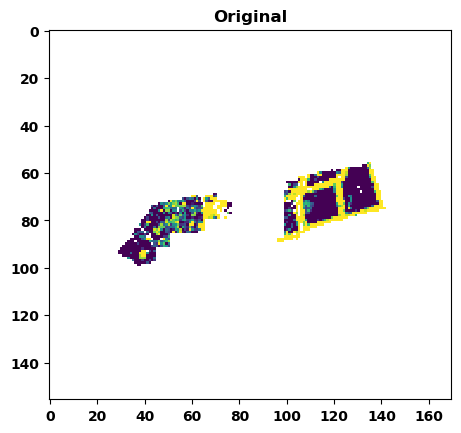

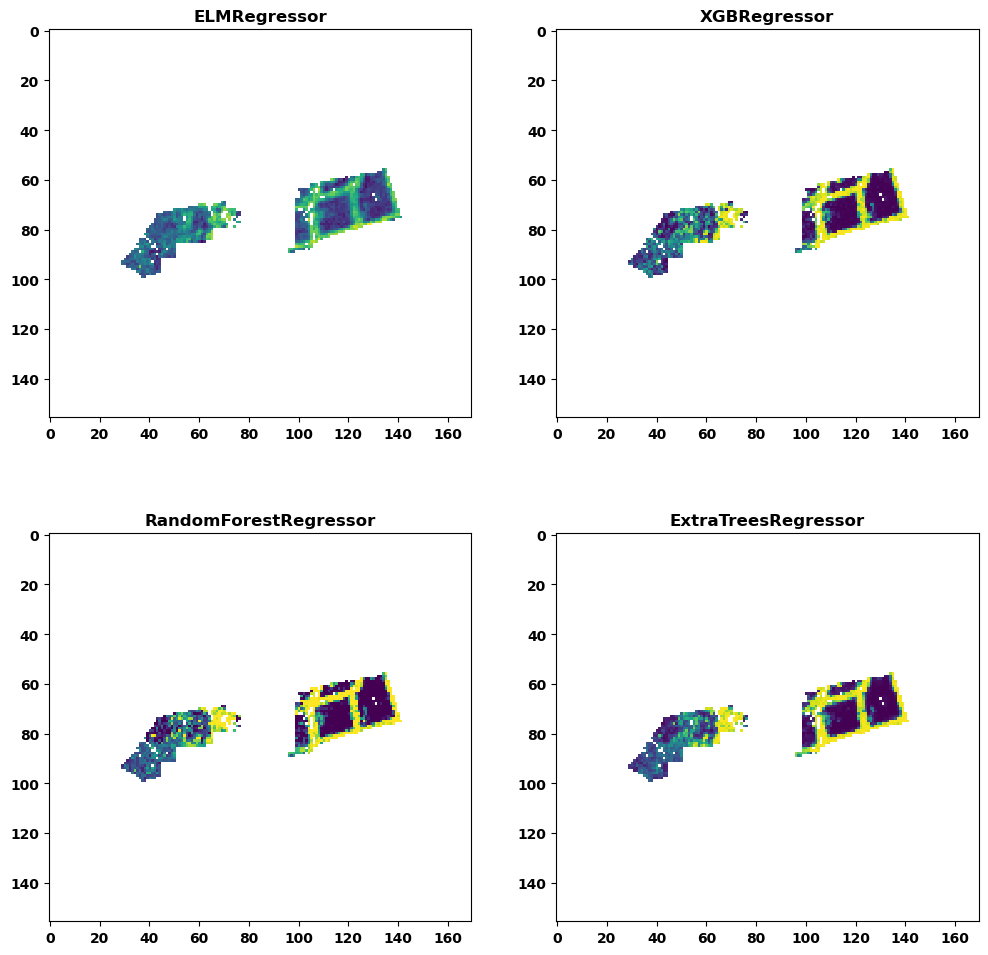

In [11]:
from sklearn.model_selection import cross_val_predict

with rasterio.open('../data/interim/fusion.tif') as src:
    raster = src.read()
    bands = src.count
    labels = list(src.descriptions)
    X = raster.transpose(1, 2, 0).reshape(-1, bands)
    
    drop_labels = []
    for i, label in enumerate(labels):
        if np.isnan(X[:, i]).all():
            drop_labels.append(label)
    
    # drop bands with no data
    for label in reversed(drop_labels):
        X = np.delete(X, labels.index(label), axis=1)
        labels.remove(label)

with rasterio.open('../data/interim/plot.tif') as src:
    plot = src.read(1)
    y = plot.flatten()
    shape = plot.shape

height_threshold = 0

# Remove NaNs while keeping the same indices
indices_array = np.arange(len(X))
mask = np.logical_and(~np.isnan(X).any(axis=1), ~np.isnan(y))
mask = np.logical_and(mask, X[:, labels.index('b1')] > height_threshold)  # TODO: height threshold
X = X[mask]
y = y[mask]
indices_array = indices_array[mask]

# Remove height pixels from plot
plot = plot.flatten()[mask]
plot_pred = np.full(np.prod(shape), np.nan)
plot_pred[indices_array] = plot
plot = plot_pred.reshape(shape)

# Predict using cross_val_predict
plots = []
for model in best_models:  # models.keys()
    y_pred = cross_val_predict(model, X, y, cv=EndMemberSplitter(5, shuffle=True))
    # y_pred = model.fit(X, y).predict(X)
    plot_pred = np.full(np.prod(shape), np.nan)
    plot_pred[indices_array] = y_pred
    plots.append(plot_pred.reshape(shape))

plt.imshow(plot, interpolation='nearest')
plt.title('Original')
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, plot, model in zip(axes.flatten(), plots, best_models):
    ax.imshow(plot, interpolation='nearest')
    ax.set_title(model.__class__.__name__)
plt.show()

In [ ]:
# Compute average of y and of predictions
np.mean(y_pred), [np.nanmean(plot) for plot in plots]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cmap = 'viridis'
num_colors = 18

viridis_cmap = plt.get_cmap(cmap)

all_colors = []
for i in range(256):
    r, g, b, a = (int(value * 255) for value in viridis_cmap(i))
    all_colors.append(f'#{r:02X}{g:02X}{b:02X}')

indices = np.linspace(0, 255, num_colors).round().astype(int)
colors = [all_colors[i] for i in indices]
print(colors)